# Simulator
### Designed to implement the code before testing it with the front end


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Importing libs


In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from sqlalchemy import create_engine
from pandas.tools.plotting import scatter_matrix

from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV,ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

DATABASE_PATH = 'app/modules/database/stock_data.sqlite'
SYMBOL='NVS'#Apple
PRED_DAYS=5 #Days to predict




## Accessing Database

In [2]:
conn = sqlite3.connect(DATABASE_PATH)                     
cur=conn.cursor()
cur.execute(''' SELECT id FROM Companies WHERE symbol = ? ''',(SYMBOL,))

symbolId = cur.fetchone()[0]                      
disk_engine = create_engine('sqlite:///{}'.format(DATABASE_PATH))  
cmd = 'SELECT Companies.name,Companies.symbol,Period.date,Data.open,Data.close,Data.low,Data.high,Data.volume,Data.adj_close\
        FROM Data LEFT JOIN Companies ON Data.symbol_id = Companies.id\
        LEFT JOIN Period ON Data.period_id = Period.id\
        WHERE symbol_id IS {}\
        ORDER BY date'.format(symbolId)
df = pd.read_sql_query(cmd,disk_engine)
df.head(10).style

## Exploiting data

Minimum price: $43.33
Maximum price: $98.55
Mean price: $71.50
Median price $73.43
Standard deviation of prices: $14.72


<IPython.core.display.Javascript object>


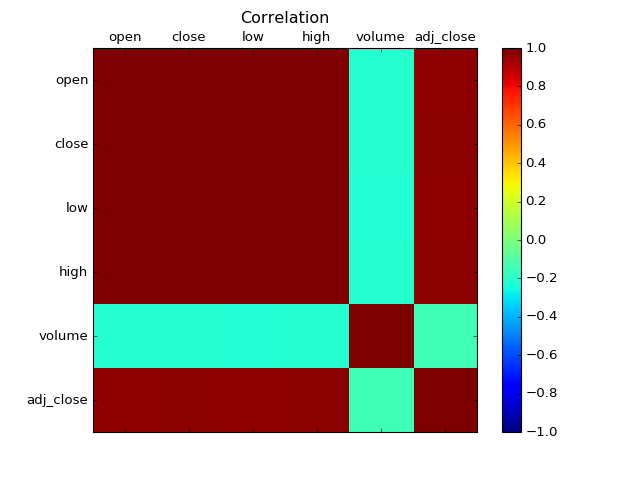

<IPython.core.display.Javascript object>


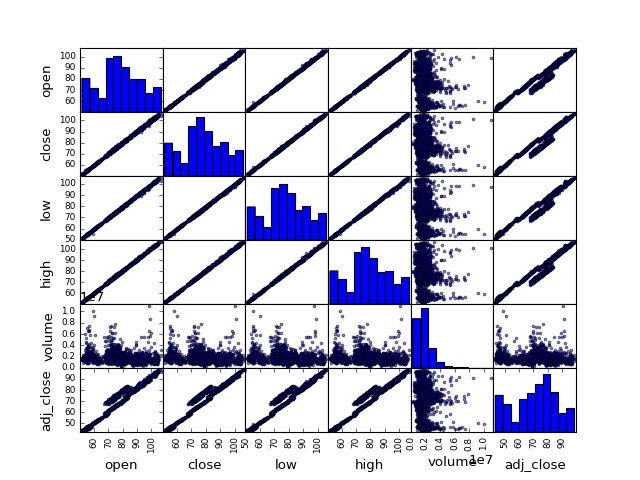

In [3]:
# Show the calculated statistics for adj close
print "Minimum price: ${:,.2f}".format(np.min(df['adj_close']))
print "Maximum price: ${:,.2f}".format(np.max(df['adj_close']))
print "Mean price: ${:,.2f}".format(np.mean(df['adj_close']))
print "Median price ${:,.2f}".format(np.median(df['adj_close']))
print "Standard deviation of prices: ${:,.2f}".format(np.std(df['adj_close']))


data = df.drop(['name','symbol','date'],axis=1)
fNames = list(data)
fig = plt.figure()
correlations = data.corr()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(fNames),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(list(fNames))
ax.set_yticklabels(list(fNames))
plt.title('Correlation')
scatter_matrix(data)
plt.show()


## Pre-processing data

Used Savgol Filter to smooth the data, avoiding outliers.

In [4]:
from scipy.signal import savgol_filter

# List of features to drop
drop = ['name','symbol','date','adj_close','volume','high','low','close']

# Adjustment Closing Prices
target = df['adj_close']

# Range of days
features = np.arange(target.size)
features = np.reshape(features,(-1,1))
#smooth_target = savgol_filter(target, 57, 5)

Smooth R2_score: 0.994243619167


<IPython.core.display.Javascript object>


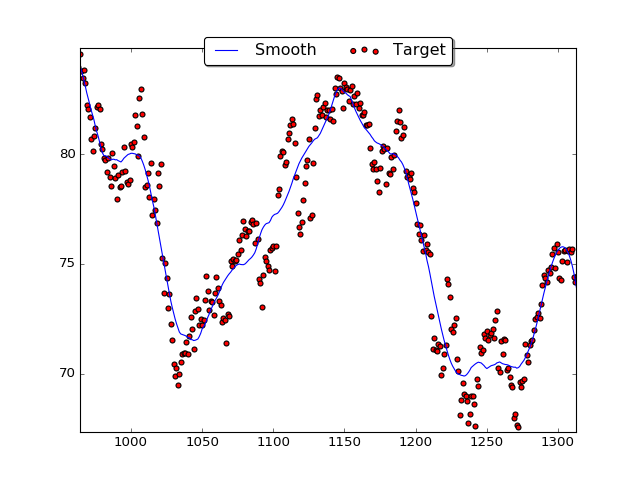

In [5]:
#Savgol Filter to smooth the surve
smooth_target = savgol_filter(target, 57, 3)
print 'Smooth R2_score: {}'.format(r2_score(target,smooth_target))

fig = plt.figure()
ax = plt.subplot(111)
ax.scatter(range(len(target)),target,c='r',label='Target')
ax.plot(smooth_target,label='Smooth')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()

# Drop the last PRED_DAYS
starget = smooth_target[0:-PRED_DAYS]
pred_target = smooth_target[-PRED_DAYS:]

sfeatures = features[0:-PRED_DAYS]
pred_features = features[-PRED_DAYS:]

# SVR

## Learning

Implementing SVR algorithm with Pipeline

In [6]:
X_train,X_test,y_train,y_test = train_test_split(sfeatures,starget,test_size=0.2,random_state=23)

params_dist = { 'svr__C'      : np.logspace(-3,2,6),
               'svr__kernel' : ['rbf'],
               'svr__gamma'  : np.logspace(-3,2,6)}
steps = [('scaler',StandardScaler()),('svr', SVR())]
pipeline = Pipeline(steps)

scoring_fnc = make_scorer(r2_score)

grid = GridSearchCV(pipeline,param_grid=params_dist,scoring=scoring_fnc,n_jobs=2)
grid.fit(X_train, y_train)
regressor = grid.best_estimator_

print 'Test Score: {}'.format(regressor.score(X_test,y_test))
print 'Full Score: {}'.format(regressor.score(features,target))
print 'Prediction Score: {}'.format(regressor.score(pred_features,pred_target))

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Test Score: 0.99993292496
Full Score: 0.994517598834
Prediction Score: 0.22287009598


# Plotting Results

<IPython.core.display.Javascript object>


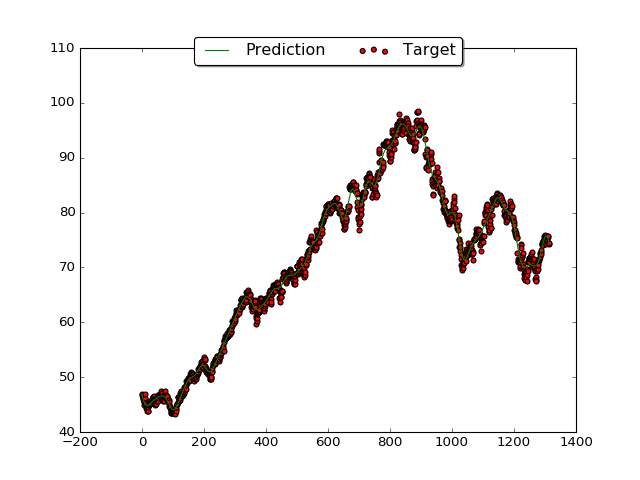

<IPython.core.display.Javascript object>


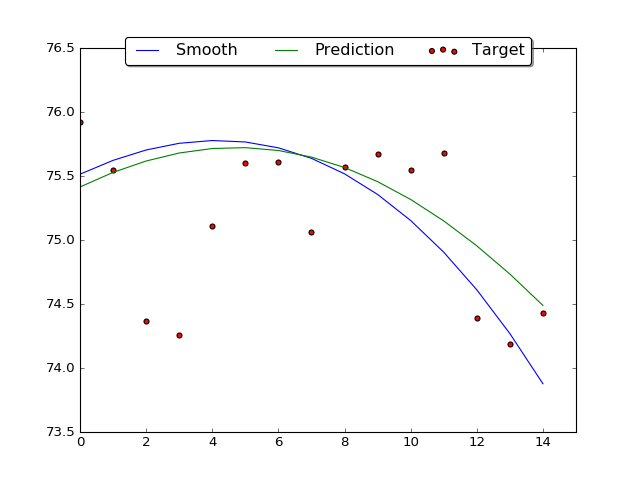

In [9]:
X_LIM=PRED_DAYS+10

fig = plt.figure()
ax1 = plt.subplot(111)
ax1.scatter(range(len(target)),target,c='r',label='Target')
ax1.plot(regressor.predict(features),'g',label='Prediction')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()

fig = plt.figure()
ax2 = plt.subplot(111)
ax2.scatter(range(len(target[-X_LIM:])),target[-X_LIM:],c='r',label='Target')
ax2.plot(smooth_target[-X_LIM:],'b',label='Smooth')
ax2.plot(regressor.predict(features[-X_LIM:]),'g',label='Prediction')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
ax2.set_xlim(0,X_LIM)
plt.show()

In [14]:
print 'Prediction Score: {}'.format(regressor.score([pred_features[0],pred_features[1]],[pred_target[0],pred_target[1]]))

Prediction Score: -1.82717269308
